In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy.optimize import least_squares

## Q1: OLS regression using scikit learn

We going to repeat the linear model of the power-plant output that we covered in the main text. However, we'll use the scikit-learn to do the OLS regression. This illustrates that there many python packages available to us to do OLS linear regression. To start, we'll read in the data.

In [2]:
# Read in the raw data
df_power = pd.read_csv("../Data/power_plant_output.csv")

In [3]:
# We extract the design matrix as a 2D numpy array. This initially corresponds to the feature columns of the dataframe.
# In this case it is all but the last column
X = df_power.iloc[:, 0:(df_power.shape[1]-1)].to_numpy()

# Now we'll extract the response vector to a numpy array
y = df_power.iloc[:, df_power.shape[1]-1].to_numpy()

Now we'll do OLS regression using the scikit-learn LinearRegression class

In [4]:
# call the fit function of the LinearRegression object, passing in the design matrix and response vector
power_scikit_model = LinearRegression().fit(X, y)

We'll compare the parameter estimates from the OLS regression done using scikit-learn with those from using the statsmodels package. First we'll have to re-do the statsmodels OLS regression.

In [5]:
# First we specify the model using statsmodels.formula.api.ols
power_statsmodel = smf.ols(formula='PE ~ AT + V', data=df_power)

# Now we fit the model to the data, i.e. we minimize the sum-of-squared residuals with respect to the model parameters
power_statsmodel_result = power_statsmodel.fit()

In [6]:
# Now compare the parameter estimates from the scikit-learn OLS regression with those from the statsmodels OLS regression
df_power_compare = pd.DataFrame({'statsmodels': power_statsmodel_result.params,
                                 'scikit-learn':np.append([power_scikit_model.intercept_], power_scikit_model.coef_)})

df_power_compare

,statsmodels,scikit-learn
Intercept,505.477434,505.477434
AT,-1.704266,-1.704266
V,-0.324487,-0.324487


As expected the parameter estimates are identical (from the two different packages) since they are using the same closed-form formula under the hood.

## Q2: Robust gradient descent

The outliers dataset is in the file Data/outliers_example.csv in the github repository. The data was generated from a model of the form $y = \beta_{0} + \beta_{1}x$. Random noise was then added to the $y$ values. There are 31 datapoints in total. Two of the datapoints are clear outliers. These are at index 27 and 28.

We'll fit a model of the form $y = \beta_{0} + \beta_{1}x$ via empirical risk minimization with the empirical risk calculated using a pseudo-Huber loss function of the form $\mathrm{L}(y, \hat{y}) = \sqrt{1 + (y-\hat{y})^{2}} - 1$. We'll do the empirical risk minimization using the simple gradient descent algorithm.

To start we'll read in and look at the data.


In [7]:
# Read in the raw data
df_outliers = pd.read_csv("../Data/outliers_example.csv")

We'll take a quick look at the data. First we'll look at a few rows of data

In [8]:
df_outliers.head(10)

,x,y
0,-2.289707,-5.298498
1,-2.086515,-2.165589
2,-1.904273,-0.552044
3,-1.387136,-2.867857
4,-1.162846,-4.174585
5,-1.042285,-3.197176
6,-0.780465,-1.259264
7,-0.648718,-7.164544
8,-0.362807,-0.236140
9,-0.244814,-0.711990


Let's look at the summary statistics for the dataset.

In [9]:
df_outliers.describe()

,x,y
count,31.000000,31.000000
mean,0.786354,3.113503
std,1.713190,10.658013
min,-2.289707,-7.164544
25%,-0.505763,-1.593490
50%,0.935624,-0.552044
75%,1.971436,4.094011
max,4.289707,46.435986


Now we'll define the functions needed to do the empirical risk minimization via gradient descent. We'll make this code generic, to work with any loss function and any model, so that if we want to change the model or loss function later on we don't have to re-write this bit of code.

In [10]:
# Define functions for performing gradient descent

def risk(X, y, beta, model, loss):
    '''
    Function to compute the empirical risk.
    
    :param X: The design matrix of feature values.
    :type X: A numpy array
    
    :param y: The response values.
    :type y: A 1D numpy array
    
    :param beta: The vector of model parameter values at which we want to 
                 evaluate the empirical risk
    :type beta: A 1D numpy array.
    
    :param model: The model prediction function. It returns
                  the prediction given input of the feature
                  vector and the model parameter vector.
    :type model: A callable object
    
    :param loss: A loss function
    :type loss: A callable object
    
    :return: The empirical risk function value
    :rtype: float
    '''
    # Initialize the risk value
    risk = 0.0
  
    # Loop over the data and increment the risk
    for i in range(X.shape[0]):
        risk += loss(y[i], model(X[i,:], beta))
        
    risk /= X.shape[0]
  
    return risk


def derivative_risk(X, y, beta, model, derivative_model, derivative_loss):
    '''
    Function to compute the derivative of the empirical risk
    with respect to the model parameter.
        
    :param X: The design matrix of feature values.
    :type X: A numpy array
    
    :param y: The response values for our example.
    :type y: A 1D numpy array
    
    :param beta: The model parameter value at which we want to 
                 evaluate the empirical risk.
    :type beta: float
    
    :param model: The model prediction function. It returns
                  the prediction given input of the feature
                  vector and the model parameter vector.
    :type model: A callable object
    
    :param derivative_model: A function which returns the 
                             derivative of the model prediction with 
                             respect to the model parameters.
    :type derivative_model: A callable object
    
    :param derivative_loss: A function which returns the 
                            derivative of the loss function with 
                            respect to the model prediction.
    :type derivative_loss: A callable object
                            
    
    :return: The derivative of the empirical risk function.
    :rtype: float
    '''
    derivative_risk = 0.0
  
    for i in range(X.shape[0]):
        yhat = model(X[i,:], beta)
        derivative_risk += (derivative_loss(y[i], yhat) * derivative_model(X[i,:], beta))

    derivative_risk /= X.shape[0]
    
    return derivative_risk   



Now we'll write functions to define our specific choices of loss function and model form

In [11]:
# Define the model
def get_q2_model():
    '''
    Function to create a callable that returns the Q2 model predictions.
    
    :return: A function that calculate the Q2 model predictions.
    :rtype: A callable object
    '''
    
    def q2_model(x, beta):
        '''
        A function that calculates the Q2 model predictions.
        
        :param x: The vector of features of the particular datapoint.
        :type x: A 1D numpy array
        
        :param beta: The vector of model parameters.
        :type beta: A 1D numpy array.
        
        :return: The Q2 model prediction.
        :rtype: float
        '''
    
        # The model is a linear model
        y = beta[0] + (beta[1]*x[0])
    
        return y
    
    return q2_model

def get_derivative_q2_model():
    '''
    Function to create a callable that returns the derivative of the 
    Q2 model prediction with respect to the model parameters.
    
    :return: A function that returns the derivative of the 
             Q2 model prediction with respect to the model parameters.
    :rtype: A callable object    
    '''
    
    def derivative_q2_model(x, beta):
        '''
        A function that calculates the derivative of the Q2 model predictions
        with respect to the model parameters
        
        :param x: The vector of features of the particular datapoint.
        :type x: A 1D numpy array
        
        :param beta: The vector of model parameters.
        :type beta: A 1D numpy array.
        
        :return: The derivative of the Q2 model prediction.
        :rtype: A 1D numpy array        
        '''
        
        # Initialize an array to hold the derivative values
        derivative = np.zeros(beta.shape)
        
        # Set the derivatives (with respect to the model parameters) of the linear model
        derivative[0] = 1.0
        derivative[1] = x[0]
        
        return derivative
    
    return derivative_q2_model

# Define the risk function
def get_pseudo_huber():
    '''
    Function to create a callable that returns the pseudo-Huber loss function values.
    
    :return: A function that calculate the loss function values.
    :rtype: A callable object    
    '''
    
    def pseudo_huber(y, yhat):
        '''
        Function that returns the pseudo-Huber loss function values.
        
        :param y: The true response value.
        :type y: float
        
        :param yhat: The model predicted response value.
        :type yhat: float.
        
        :return: The pseudo-Huber loss function value
        :rtype: float
        '''
    
        # Calculate the residual
        residual = y - yhat
        
        # Calculate the pseudo-Huber loss
        loss = np.sqrt(1.0 + np.power(residual, 2.0)) - 1.0
    
        return loss
    
    return pseudo_huber

def get_derivative_pseudo_huber():
    '''
    Function to create a callable that returns the derivative of the pseudo-Huber 
    loss function with respect to the model prediction.
    
    :return: Function that returns the derivative of the pseudo-Huber 
             loss function with respect to the model prediction.
    :rtype: A callable object    
    '''
    
    def derivative_pseudo_huber(y, yhat):
        '''
        Function that returns the derivative of the pseudo-Huber 
        loss function with respect to the model prediction.
        
        :param y: The true response value.
        :type y: float
        
        :param yhat: The model predicted response value.
        :type yhat: float.
        
        :return: The derivative of the pseudo-Huber loss function.
        :rtype: float
        '''
        
        # Calculate the residual
        residual = y - yhat
        
        # Calculate the derivative
        derivative_loss = -residual / np.sqrt(1.0 + np.power(residual, 2.0))
        
        return derivative_loss
    
    return derivative_pseudo_huber

Now create the relevant data arrays and functions to do the gradient descent

In [12]:
# Extract the feature and response values to 
# numpy arrays
X_outliers = df_outliers['x'].to_numpy(copy=True)
y_outliers = df_outliers['y'].to_numpy(copy=True)

# reshape the feature values to a matrix, because we have defined
# the model function to take a feature vector as input in general
X_outliers.shape=(len(X_outliers),1)

# Create the functions to calculate the model, the loss and their
# derivatives
q2_model = get_q2_model() # gets the model function
q2_derivative_model = get_derivative_q2_model() # gets the derivative of the model function

q2_loss = get_pseudo_huber() # gets the loss function
q2_derivative_loss = get_derivative_pseudo_huber() # gets the derivative of the loss function

Now do the gradient descent

In [13]:
# Set the learning rate and the number of iterations we want to perform
eta=0.01
n_iter=5000

# Initialize arrays to hold the sequence of 
# parameter estimates and empirical risk values
beta_learn=np.zeros((1+n_iter, 2))
risk_learn=np.full(1+n_iter, np.nan)

# Set the starting estimate for the
# model parameters
beta_learn[0,0]=0.0
beta_learn[0,1]=1.0

# Iterate using the gradient descent update rule
for iter in range(n_iter):
    risk_learn[iter] = risk(X_outliers, y_outliers, beta_learn[iter, :], q2_model, q2_loss)
    beta_learn[iter+1, :] = beta_learn[iter] -(eta*derivative_risk(X_outliers, y_outliers, beta_learn[iter, :], q2_model, q2_derivative_model, q2_derivative_loss))

In [14]:
# The final parameter estimates are,
beta_learn[-1, ]

array([-0.5084421 ,  2.03284684])

In [15]:
# Let's compare to the parameter estimates we would have got with OLS regression
outlier_model_ols1 = smf.ols(formula='y ~ x', data=df_outliers)
outlier_model_ols1_result = outlier_model_ols1.fit()

# We'll also do an OLS regression with the two outlier points removed
outlier_model_ols2 = smf.ols(formula='y ~ x', data=df_outliers[~df_outliers.index.isin([27, 28])])
outlier_model_ols2_result = outlier_model_ols2.fit()

# Now compare the parameter estimates from the OLS regression with those from the gradient descent with the 
# robust loss function
df_outliers_compare = pd.DataFrame({'OLS': outlier_model_ols1_result.params, 'OLS Outliers Removed':outlier_model_ols2_result.params, 
                           'pseudo-Huber Gradient Descent':beta_learn[-1, ]})
df_outliers_compare

,OLS,OLS Outliers Removed,pseudo-Huber Gradient Descent
Intercept,0.216482,-0.577907,-0.508442
x,3.684120,1.889414,2.032847


You can see how the outliers have significantly increased the gradient estimate in the standard OLS regression. The parameter estimates from the robust gradient descent are closer to the parameter estimates from the OLS regression with the outliers removed. They are not identical because, i) the robust loss function will reduce the effects of the outliers but not remove the outlier data points completely, ii) since the OLS regression has had the outliers removed, we are comparing model fits on two different datasets, so we are not comparing like with like, and so we would expect some differences.

The parameters used to generate the data were, in fact, 1.0 for the intercept and 1.5 for the gradient. We can see that even when we use robust gradient descent or remove the outliers from the OLS regresion, there is still a large difference between the parameter estimates and the true parameter values. This is because, i) we are using a finite dataset, in fact quite a small one, consisting of only 31 datapoint, ii) the random component in the data was deliberately set to have a large variance. Overall this means there is large sampling variation in the data and hence in the parameter estimates, even when we either mitigate or remove the effect of the outliers. 

## Q3: Non-linear least squares minimization using simple gradient descent

The data in the file Data/nls_example.csv contains data that has been generated according to the relationship,
$y = \beta_{0} + \beta_{1}e^{-\beta_{2}x}$. The $y$ values in the dataset have been corrupted by noise, i.e,. they also contain an additive random component. We'll use a simple gradient descent algorithm to estimate the model parameters via least squares minimization. We'll initialize the parameter estimate at $\beta_{0}=1, \beta_{1}=5, \beta_{2}=1$. We'll run the gradient descent algorithm for 10000 iterations. To start, we'll read in the data.


In [16]:
# Read in the raw data
df_nls = pd.read_csv("../Data/nls_example.csv")

We can reuse the functions defined in Q2 to do the gradient descent, we just need to redefine the loss function and the model we use.

In [17]:
# Define the model
def get_q3_model():
    '''
    Function to create a callable that returns the Q3 model predictions.
    
    :return: A function that calculate the Q3 model predictions.
    :rtype: A callable object
    '''
    
    def q3_model(x, beta):
        '''
        A function that calculates the Q3 model predictions.
        
        :param x: The vector of features of the particular datapoint.
        :type x: A 1D numpy array
        
        :param beta: The vector of model parameters.
        :type beta: A 1D numpy array.
        
        :return: The Q3 model prediction.
        :rtype: float
        '''
    
        # The model is a non-linear model
        y = beta[0] + (beta[1]*np.exp(-beta[2]*x[0]))
    
        return y
    
    return q3_model

def get_derivative_q3_model():
    '''
    Function to create a callable that returns the derivative of the 
    Q3 model prediction with respect to the model parameters.
    
    :return: A function that returns the derivative of the 
             Q3 model prediction with respect to the model parameters.
    :rtype: A callable object    
    '''
    
    def derivative_q3_model(x, beta):
        '''
        A function that calculates the derivative of the Q3 model predictions
        with respect to the model parameters
        
        :param x: The vector of features of the particular datapoint.
        :type x: A 1D numpy array
        
        :param beta: The vector of model parameters.
        :type beta: A 1D numpy array.
        
        :return: The derivative of the Q3 model prediction.
        :rtype: A 1D numpy array        
        '''
        
        # Initialize an array to hold the derivative values
        derivative = np.zeros(beta.shape)
        
        # Set the derivatives (with respect to the model parameters) of the linear model
        derivative[0] = 1.0
        derivative[1] = np.exp(-beta[2]*x[0])
        derivative[2] = -beta[1]*x[0]*np.exp(-beta[2]*x[0])
        
        return derivative
    
    return derivative_q3_model

# Define the risk function
def get_squared_loss():
    '''
    Function to create a callable that returns the squared-loss function values.
    
    :return: A function that calculate the loss function values.
    :rtype: A callable object    
    '''
    
    def squared_loss(y, yhat):
        '''
        Function that returns the squared-loss function values.
        
        :param y: The true response value.
        :type y: float
        
        :param yhat: The model predicted response value.
        :type yhat: float.
        
        :return: The squared-loss function value
        :rtype: float
        '''
    
        # Calculate the residual
        residual = y - yhat
        
        # Calculate the pseudo-Huber loss
        loss = np.power(residual, 2.0)
    
        return loss
    
    return squared_loss

def get_derivative_squared_loss():
    '''
    Function to create a callable that returns the derivative of the 
    squared-loss function with respect to the model prediction.
    
    :return: Function that returns the derivative of the squared-loss 
             function with respect to the model prediction.
    :rtype: A callable object    
    '''
    
    def derivative_squared_loss(y, yhat):
        '''
        Function that returns the derivative of the squared-loss  
        function with respect to the model prediction.
        
        :param y: The true response value.
        :type y: float
        
        :param yhat: The model predicted response value.
        :type yhat: float.
        
        :return: The derivative of the squard-loss function.
        :rtype: float
        '''
        
        # Calculate the residual
        residual = y - yhat
        
        # Calculate the derivative
        derivative_loss = -2.0*residual
        
        return derivative_loss
    
    return derivative_squared_loss

Now create the relevant data arrays and functions to do the gradient descent

In [18]:
# Extract the feature and response values to 
# numpy arrays
X_nls = df_nls['x'].to_numpy(copy=True)
y_nls = df_nls['y'].to_numpy(copy=True)

# reshape the feature values to a matrix, because we have defined
# the model function to take a feature vector as input in general
X_nls.shape=(len(X_nls),1)

# Create the functions to calculate the model, the loss and their
# derivatives
q3_model = get_q3_model() # gets the model function
q3_derivative_model = get_derivative_q3_model() # gets the derivative of the model function

q3_loss = get_squared_loss() # gets the loss function
q3_derivative_loss = get_derivative_squared_loss() # gets the derivative of the loss function

Now do the gradient descent

In [19]:
# Set the learning rate and the number of iterations we want to perform
eta=0.1
n_iter=10000 # This can take a few minutes to run

# Initialize arrays to hold the sequence of 
# parameter estimates and empirical risk values
beta_learn_nls=np.zeros((1+n_iter, 3))
risk_learn_nls=np.full(1+n_iter, np.nan)

# Set the starting estimate for the
# model parameters
beta_learn_nls[0,0]=1.0
beta_learn_nls[0,1]=5.0
beta_learn_nls[0,2]=1.0

# Iterate using the gradient descent update rule
for iter in range(n_iter):
    risk_learn_nls[iter] = risk(X_nls, y_nls, beta_learn_nls[iter, :], q3_model, q3_loss)
    beta_learn_nls[iter+1, :] = beta_learn_nls[iter] -(eta*derivative_risk(X_nls, y_nls, beta_learn_nls[iter, :], q3_model, q3_derivative_model, q3_derivative_loss))

Let's look at whether the gradient descent has converged. We'll plot from iteration 50 onwards. The first few iterations produce the biggest decrease in the risk and so distort the scale of the plot a little.

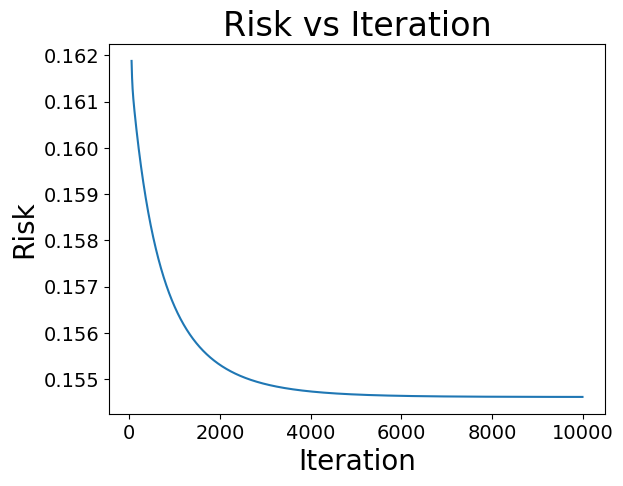

In [20]:
# Plot the risk estimate at each iteration
plt.plot(range(50, n_iter+1), risk_learn_nls[50:])
plt.title('Risk vs Iteration', fontsize=24)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Risk', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

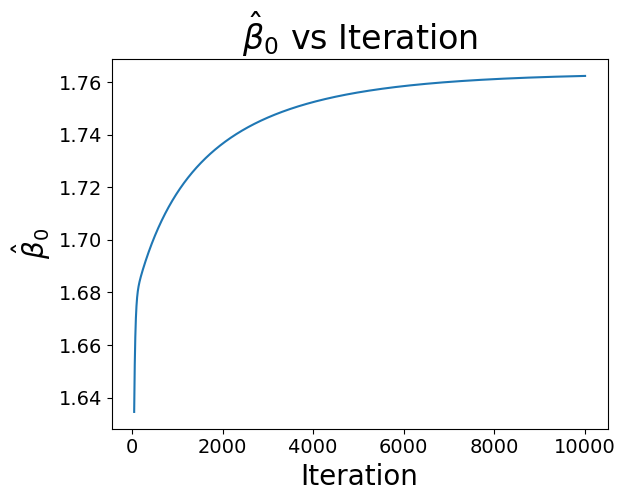

In [21]:
# Plot parameter estimates at each iteration
plt.plot(range(50, n_iter+1), beta_learn_nls[50:,0])
plt.title(r'$\hat{\beta}_{0}$ vs Iteration', fontsize=24)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'$\hat{\beta}_{0}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

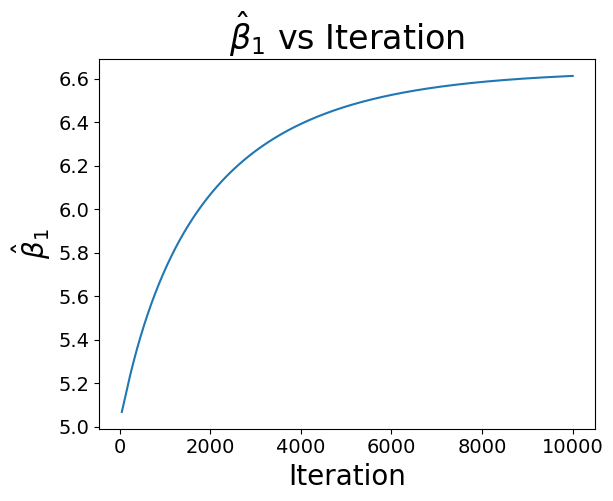

In [22]:
# Plot parameter estimates at each iteration
plt.plot(range(50, n_iter+1), beta_learn_nls[50:,1])
plt.title(r'$\hat{\beta}_{1}$ vs Iteration', fontsize=24)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'$\hat{\beta}_{1}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

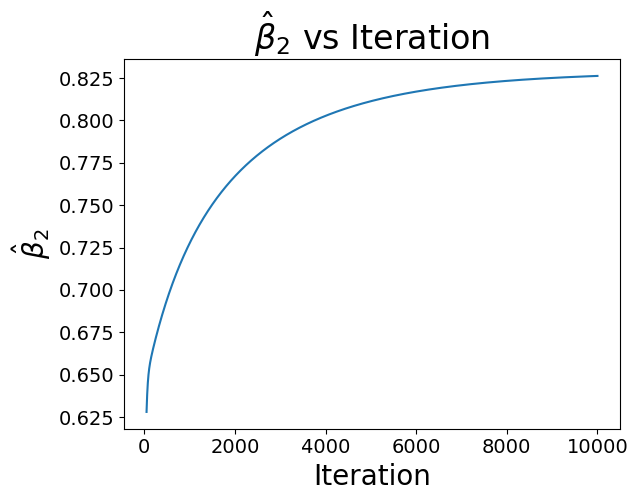

In [23]:
# Plot parameter estimates at each iteration
plt.plot(range(50, n_iter+1), beta_learn_nls[50:,2])
plt.title(r'$\hat{\beta}_{2}$ vs Iteration', fontsize=24)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel(r'$\hat{\beta}_{2}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The simple gradient descent looks like it has converged and so produced sensible parameter estimates. But let's look at what we get if we do the least squares minimization using a more sophisticated algorithm. For this we'll use the scipy.optimize.least_squares function. To use this we first need to create a function that returns the model residuals given the model parameters as input.

In [24]:
# Define the residuals function
def get_residuals_function(X, y, model):
    '''
    Function to create a callable that returns the residuals of the 
    model predictions.
    
    :param X: The design matrix of feature values.
    :type X: A numpy array
    
    :param y: The response values.
    :type y: A 1D numpy array
    
    :param model: A function that returns the model predictions.
    :type model: A callable object
    
    :return: Function that returns the residuals.
    :rtype: A callable object     
    '''
    
    def residuals_function(beta):
        '''
        Function that returns the residuals of the 
        model predictions.
        
        :param beta: A vector of model parameters.
        :type beta: A 1D numpy array
        
        :return: The vector of model residuals.
        :rtype: A 1D numpy array
        '''
        residuals = np.zeros(len(y))
        
        for i in range(len(y)):
            residuals[i] = y[i] - model(X[i, :], beta)
        
        return residuals
    
    return residuals_function
    

Now do the least squares minimization using the scipy.optimize.least_squares function

In [25]:
scipy_nls_result = least_squares(get_residuals_function(X_nls, y_nls, q3_model), np.array([0.0, 1.0, 1.0]))

Let's compare the output from the simple gradient descent and the more sophisticated algorithm

In [26]:
df_nls_compare = pd.DataFrame({'Gradient descent': beta_learn_nls[-1,:], 
                               'Scipy NLS':scipy_nls_result.x})
df_nls_compare

,Gradient descent,Scipy NLS
0,1.762413,1.763492
1,6.611920,6.636653
2,0.826309,0.828915


The simple gradient descent algorithm appears to have produced similar parameter estimates to the scipy least squares algorithm. However, we had to run the gradient descent algorithm for 10000 iterations and we started from a initialization of (1.0, 5.0, 1.0) that is reasonably close to the optimal values of (1.763, 6.637, 0.829). In contrast, we started the scipy least squares algorithm from (0.0, 1.0, 1.0) and only took 15 iterations of the scipy algorithms. This highlights how more sophisticated optimization algorithms are required for least squares problems when we have more complex non-linear models. This is particularly true when it comes to parameter estimation for neural networks, where adaptive gradient descent algorithms such as the Adam optimizer are available to us.